Attached is the sample data for sales of a company from 2015-01-01 to 2015-08-01. We have gathered information about sales of sample items along with promotion schedule during 2015. 
Our goal is to measure the effects of promotion on sales and give recommendations to marketing department for future promotion campaigns. 
3.1	Data = Question3.1data.csv:
The data contains daily sales of sample of items in several stores on a specific time frame. 
Negative sale quantities represents returns. Each row represents a sale (or return) activity for an item in a store at a specific day. If there is no observation in a certain day for any item, you can assume there is no sales for that item at that day.

3.2	Data= Question3.2data.csv:
The data contains beginning and the end dates of 6 promotions that took place in 2015. 
The 6 promotion weeks like on below :

Promo1,2/10/2015,2/17/2015
Promo2,3/15/2015,3/22/2015
Promo3,5/24/2015,6/1/2015
Promo4,6/21/2015,6/28/2015
Promo5,1/9/2015,6/9/2015
Promo6 ,20/11/2015,27/11/2015

3.3	Data= Question3.3data.csv:

A.	Your goal is to model the effect of promotion on products. 

Product with higher average weekly sale per store during non-promotion periods will be called “Fast items” and items with lower

weekly average sale per store will be labeled as “Slow items”, items in between will be called “Medium items”. Grouping 

parameters selection is left to you. Apply similar approach to Stores as well.

a.	What are your criteria for separating Fast, Medium and Slow items? Why?

b.	Which items experienced the biggest sale increase during promotions?

c.	Is there any significant difference between promotion impacts of the Fast versus Slow items?

B.	You are asked to measure how well your model have worked on this new data.

a.What measure would you use for goodness of fit?

b.How good is your model developed in step 1?

c.What are the main problem points causing bad fits?

d.What is the impact of Promo5&Promo6? Compare the result with predicted and the real data.





First I am going to import the 3.1 data which contain datas from 2015-01-01 to 2015-08-01. I need only sales positive values, so return values must be eleminated.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.distributions.empirical_distribution import ECDF
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('C://Users/dell/.spyder-py3/Question3.1data.csv')

In [3]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d') # formating date

In [4]:
mask = df['SalesQuantity'] < 0
df['Sales'] = df['SalesQuantity'].mask(mask)
df['Returns'] = df['SalesQuantity'].mask(~mask)
df.fillna(0,inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1873618 entries, 0 to 1873617
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Date           datetime64[ns]
 1   StoreCode      int64         
 2   ProductCode    int64         
 3   SalesQuantity  int64         
 4   Sales          float64       
 5   Returns        float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 85.8 MB


,Date,StoreCode,ProductCode,SalesQuantity,Sales,Returns
0,2015-01-01,8,9,-1,0.0,-1.0
1,2015-01-01,131,9,1,1.0,0.0
2,2015-01-01,144,9,2,2.0,0.0
3,2015-01-01,203,9,2,2.0,0.0
4,2015-01-01,256,9,0,0.0,0.0


In [5]:
df.drop(['SalesQuantity'],axis=1,inplace=True)
df.drop(['StoreCode'],axis=1,inplace=True)
df_sales=df.groupby(['Date','ProductCode']).Sales.sum().reset_index()

df_sales.head()

,Date,ProductCode,Sales
0,2015-01-01,1,17.0
1,2015-01-01,2,15.0
2,2015-01-01,3,7.0
3,2015-01-01,4,22.0
4,2015-01-01,5,12.0


In the next part,rolling data to weekly average sales for each item. There is one critic step in this process: 
When date is formatted in the first section,we get actual week dates based on 2015 calendar.
In this reason, I should remove first week from my dataset becasue it has only 3 days in that week.
Smilarly, in the last week involve 6 days but i dont want to delete this one, 
thus i will apply weekly average sale dividing it with 6 days.
    

In [6]:
df_sales.set_index('Date',inplace=True)
df_sales=df_sales.groupby([pd.Grouper(freq='W'),'ProductCode'])
df_sales=df_sales['Sales'].sum().div(7)
df_sales=df_sales.to_frame()
df_sales=df_sales.reset_index(level=['Date','ProductCode'])
df_sales['Sales']=np.where(df_sales['Date']=='2015-08-02',(df_sales['Sales']*7)/6,df_sales['Sales'])
df_sales=df_sales.round(0)
df_sales.set_index('Date',inplace=True)

df_sales=df_sales.loc['20150111':'20150802']
df.info()
df_sales.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1873618 entries, 0 to 1873617
Data columns (total 4 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Date         datetime64[ns]
 1   ProductCode  int64         
 2   Sales        float64       
 3   Returns      float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 57.2 MB


,ProductCode,Sales
Date,,
2015-01-11,1,49.0
2015-01-11,2,35.0
2015-01-11,3,33.0
2015-01-11,4,40.0
2015-01-11,5,53.0


Weekly average sales for each product dataframe is created.Coming up next that creating "isPromo" column. In this way it will be easy to separate data as "Promo-period" and "Non-Promo-Peirod" datas. 

In [7]:
df_sales=df_sales.reset_index(level=['Date'])
df_sales['isPROMO']=np.where((df_sales.Date=='2015-02-15') |(df_sales.Date=='2015-03-22')|(df_sales.Date=='2015-05-31')|(df_sales.Date=='2015-06-28'),'Yes','No')
df_sales.columns=['Date','ProductCode','Weekly_Units_Sold','Is_Promo']
df_sales.head()

,Date,ProductCode,Weekly_Units_Sold,Is_Promo
0,2015-01-11,1,49.0,No
1,2015-01-11,2,35.0,No
2,2015-01-11,3,33.0,No
3,2015-01-11,4,40.0,No
4,2015-01-11,5,53.0,No


Now, Kernel Density Estimation will be used for clustering item as Fast,Medium and Slow items based on each items "Weekly_Units_Sold" column quantity.
I choose the Kernel Density Estimation because I have only one feature column for unsupervised clustering and depending on my research KDE ensures the best solution under this circumstance.  

First,all the ProductCode should be groupped with aggregation their weekly average quantity. 

In [8]:
df_sales_agg=df_sales.groupby('ProductCode').Weekly_Units_Sold.sum().reset_index()
df_sales_agg.head()

,ProductCode,Weekly_Units_Sold
0,1,1605.0
1,2,1215.0
2,3,907.0
3,4,1071.0
4,5,1304.0


df_sales_agg shows us 30 weeks total Weekly_units_Sold for each 317 product code. 

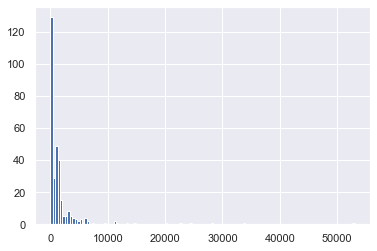

In [9]:
_ = plt.hist(df_sales_agg['Weekly_Units_Sold'], bins='auto')

As seen the histogram on the above, our data is more looking like an exponential distrubition.

In [10]:
temp=df_sales_agg[df_sales_agg['Weekly_Units_Sold']<100]
len(temp)

85

85 different product out of the 317 product was sold less than 100 sales quantity in total 30 weeks on 340 different stores.
Approximately 100/(30 weeks) 3.33 weekly average product was sold on 340 different stores. 
This is significantly small number for the company.In this reason, This productcodes will be eliminated as a outlier.
Smilar way product code which 'Weekly_Units_Sold' quantity greater than 11600 is not included to KDE operation.




In [11]:
temp1=df_sales_agg[df_sales_agg['Weekly_Units_Sold']>11600]
len(temp1)

9

In [12]:
df_sales_agg=df_sales_agg[df_sales_agg['Weekly_Units_Sold']>100]
df_sales_agg=df_sales_agg[df_sales_agg['Weekly_Units_Sold']<11600]

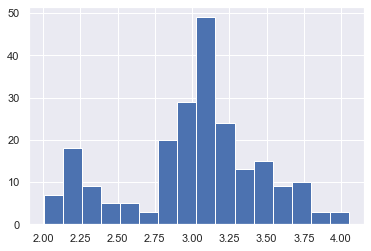

In [13]:
X=df_sales_agg.drop(['ProductCode'],axis=1)
X=np.array(X).reshape(-1,1)
X=np.log10(X)
_= plt.hist(X, bins='auto')


After applying log() function, data is more close to normal distribution.
This is necessary in order to KDE algorithim generate more proper results.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



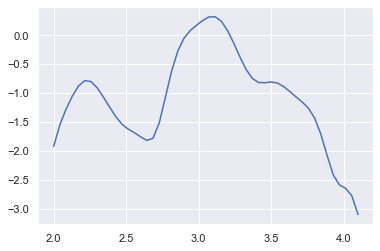

Minima: [2.64285714 3.45714286]
Maxima: [2.21428571 3.11428571 3.5       ]


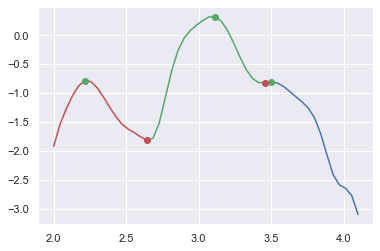

In [14]:
from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot

kde = KernelDensity(kernel='gaussian',bandwidth=0.08).fit(X)
s = linspace(2,4.1)
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)
plt.show()
from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])

plot(s[:mi[0]+1], e[:mi[0]+1], 'r',
     s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',
     s[mi[1]:], e[mi[1]:], 'b',
     s[ma], e[ma], 'go',
     s[mi], e[mi], 'ro')


In [15]:
min1=10**2.64285714
min2=10**3.45714286
min1

439.3970531853672

In [16]:
min2

2865.1202885128746

The two red point(minimas)tells us the boundires of clusters. 
If a product code 30 weeks total weekly average sold quantity is less than 439;
Slow product, else if between 439 and 2865; Medium product,
else greater than 2865; Fast product.

In [17]:
df_sales_30week_agg=df_sales.groupby('ProductCode').Weekly_Units_Sold.sum().reset_index()
df_sales_30week_agg.head()

,ProductCode,Weekly_Units_Sold
0,1,1605.0
1,2,1215.0
2,3,907.0
3,4,1071.0
4,5,1304.0


In [18]:
def clusters(df_sales_30week_agg):
  if df_sales_30week_agg['Weekly_Units_Sold']<439:
    return 'Slow'
  elif (df_sales_30week_agg['Weekly_Units_Sold']>=439)&(df_sales_30week_agg['Weekly_Units_Sold']<=2865):
    return 'Med'
  elif df_sales_30week_agg['Weekly_Units_Sold']>2865:
    return 'Fast'
df_sales_30week_agg['Clusters'] = df_sales_30week_agg.apply(clusters, axis=1)
df_sales_30week_agg=df_sales_30week_agg.drop(['Weekly_Units_Sold'],axis=1)
df_sales=pd.merge(df_sales,df_sales_30week_agg,on='ProductCode')
df_sales.set_index('Date',inplace=True)
df_sales.head()

,ProductCode,Weekly_Units_Sold,Is_Promo,Clusters
Date,,,,
2015-01-11,1,49.0,No,Med
2015-01-18,1,56.0,No,Med
2015-01-25,1,35.0,No,Med
2015-02-01,1,56.0,No,Med
2015-02-08,1,59.0,No,Med


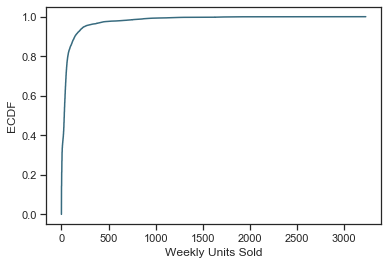

In [19]:
sns.set(style = "ticks")
c = '#386B7F'

cdf = ECDF(df_sales['Weekly_Units_Sold'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Weekly Units Sold'); plt.ylabel('ECDF');

    

Although in the best week, a store sold more than 3000 units, 
about 90% of the time, weekly units sold did not exceed 500.

In [20]:
df_sales_fast=df_sales[df_sales['Clusters']=='Fast']
len(list(df_sales_fast.ProductCode.unique()))


45

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



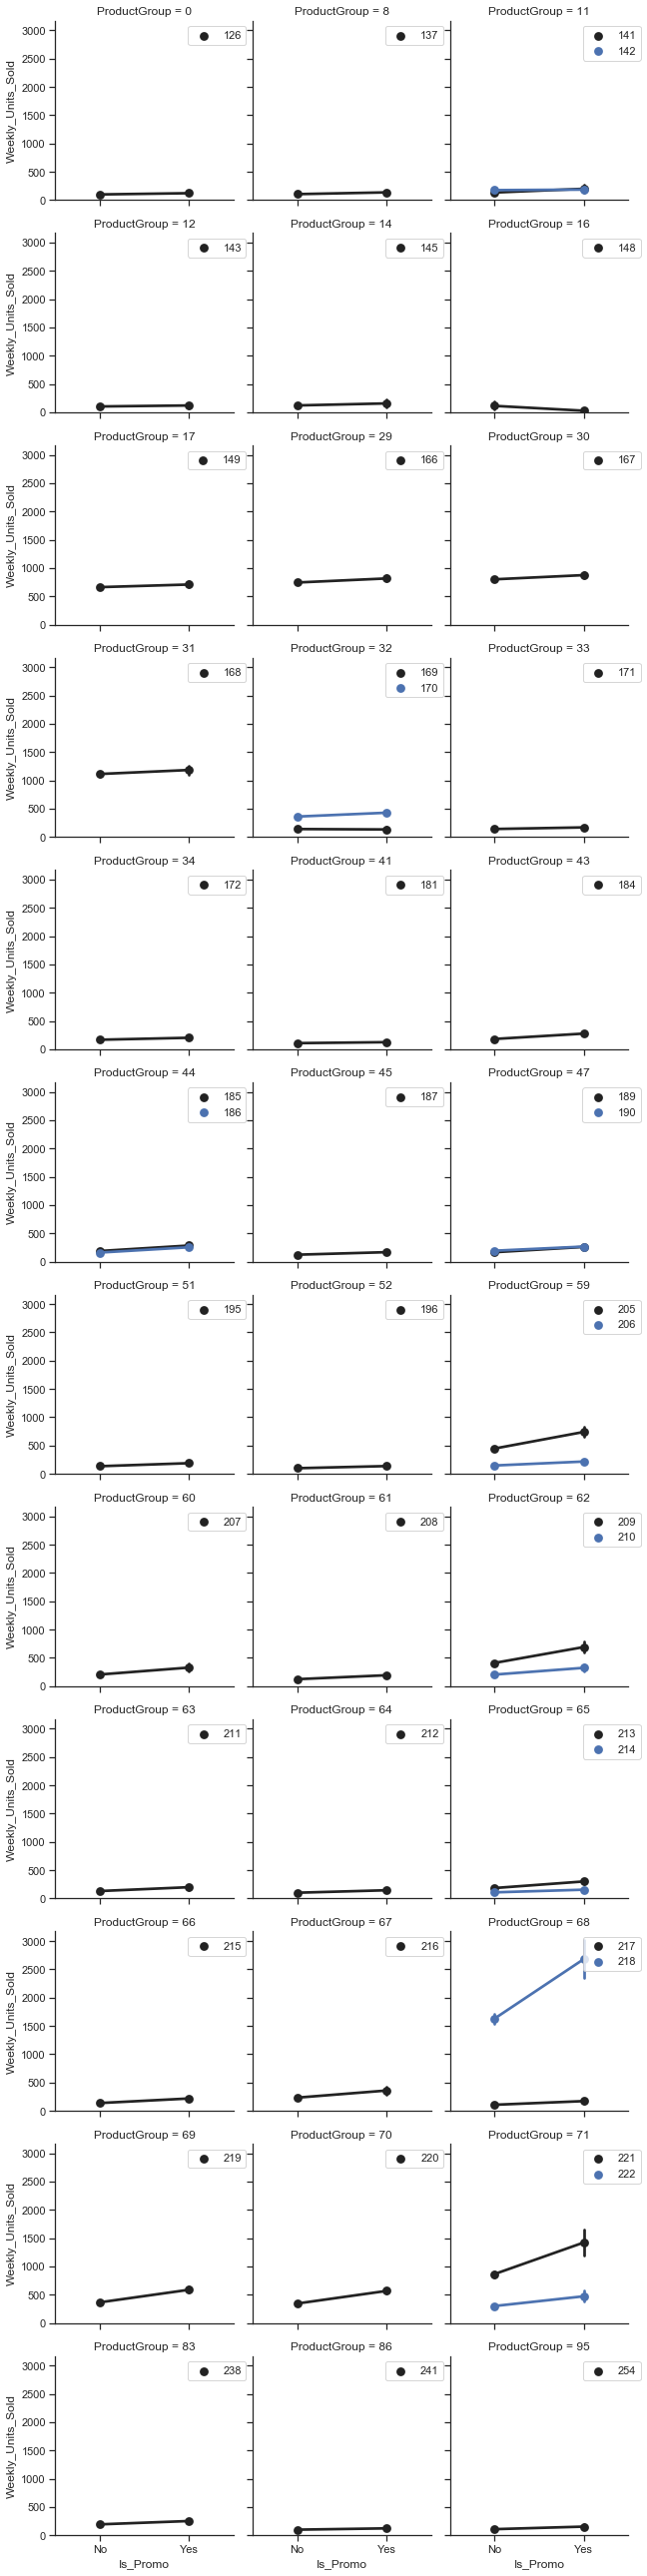

In [21]:
Ngroups = 96
df_sales_fast['ProductGroup'] = pd.cut(df_sales_fast['ProductCode'],Ngroups, labels=False)
g = sns.FacetGrid(data=df_sales_fast, col='ProductGroup', col_wrap=3)
g.map_dataframe(sns.pointplot, 'Is_Promo', 'Weekly_Units_Sold', order=['No','Yes'], hue='ProductCode')
g.set(ylim=(0, None))
for ax in g.axes.ravel():
    ax.legend(loc=1, bbox_to_anchor=(1.1,1))


It seems that Promotion period have a positive impact for the business. For most of the Fast product, weekly unit sold during the promotion is higher than the normal days, while product 148 had a slightly decrease during the promotion period.

Weekly units sold for product 218 witnessed the most significant increase during the promotion period. 

In [22]:
df_sales_med=df_sales[df_sales['Clusters']=='Med']
len(list(df_sales_med.ProductCode.unique()))


142

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



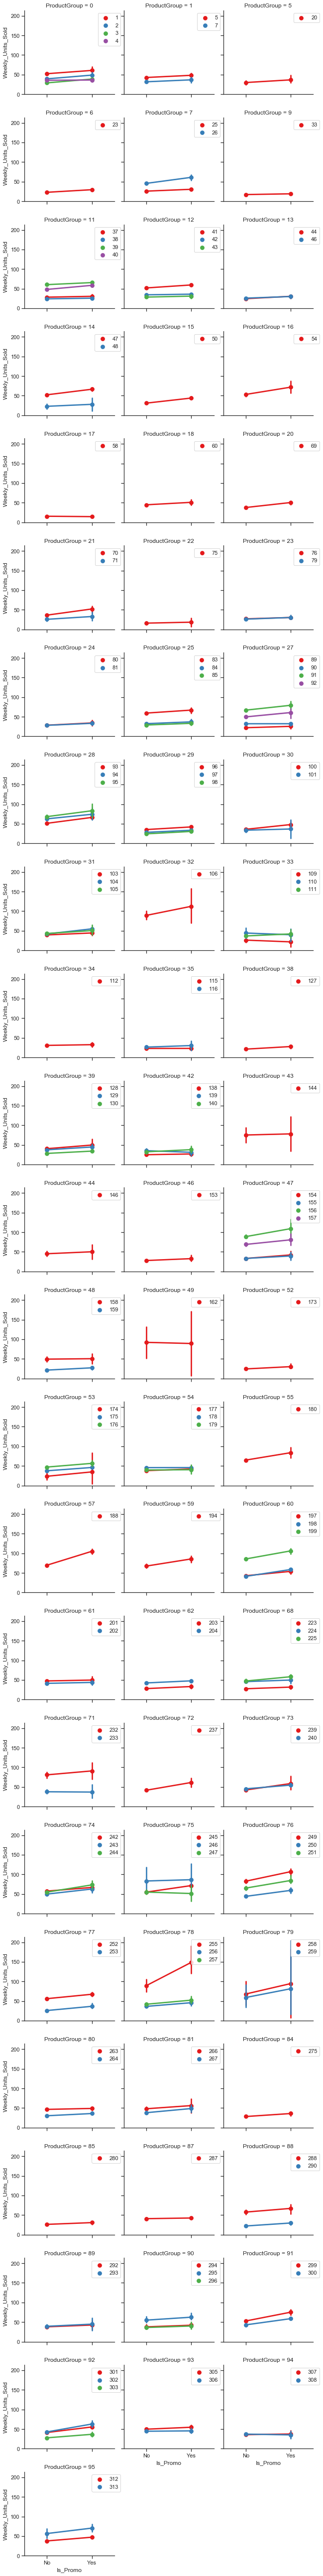

In [23]:
df_sales_med['ProductGroup'] = pd.cut(df_sales_med['ProductCode'],Ngroups, labels=False)
g = sns.FacetGrid(data=df_sales_med, col='ProductGroup', col_wrap=3)
g.map_dataframe(sns.pointplot, 'Is_Promo', 'Weekly_Units_Sold', order=['No','Yes'], hue='ProductCode',palette="Set1")
g.set(ylim=(0, None))
for ax in g.axes.ravel():
    ax.legend(loc=1, bbox_to_anchor=(1.1,1))

Except the minor decline tendancy of 5 product Code namely, 58,90,109,139,247
The rest of the 137 products was risen to higher values during promotion period.

Weekly units sold figure of product 255 and 188 had the most significant increase during the promotion period.

In [24]:
df_sales_slow=df_sales[df_sales['Clusters']=='Slow']
len(list(df_sales_slow.ProductCode.unique()))


130

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



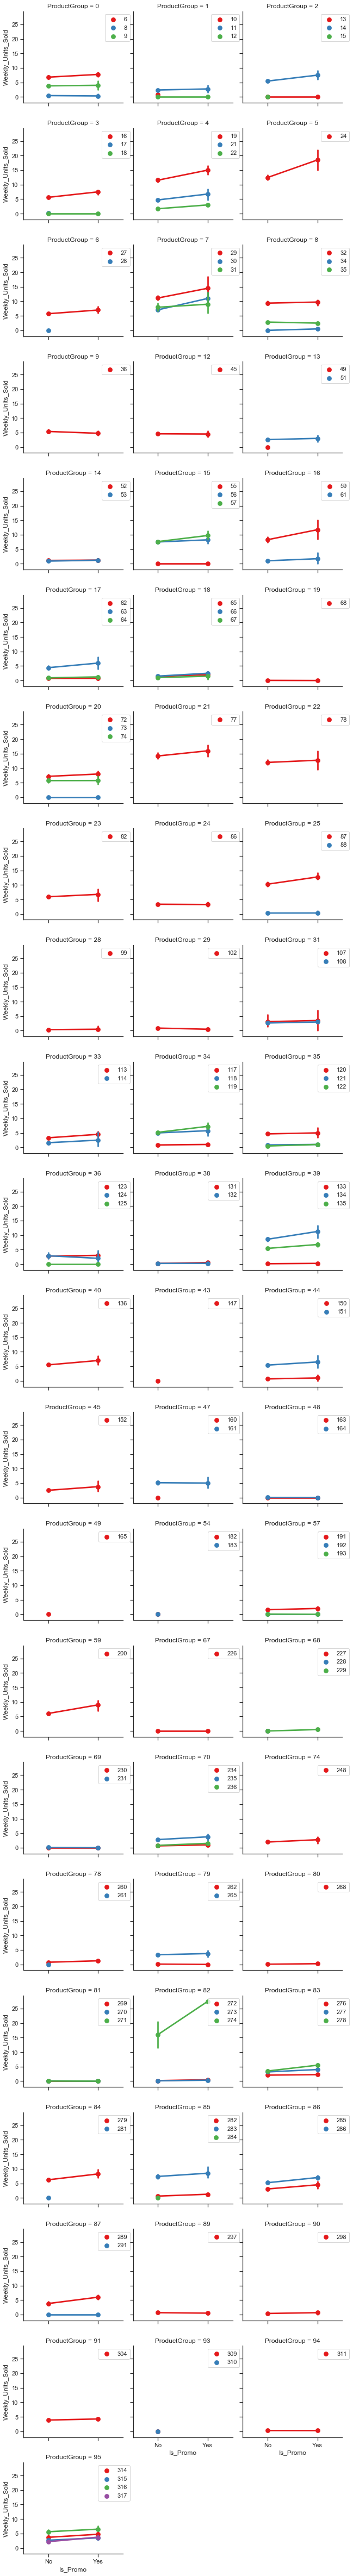

In [25]:
df_sales_slow['ProductGroup'] = pd.cut(df_sales_slow['ProductCode'],Ngroups, labels=False)
g = sns.FacetGrid(data=df_sales_slow, col='ProductGroup', col_wrap=3)
g.map_dataframe(sns.pointplot, 'Is_Promo', 'Weekly_Units_Sold', order=['No','Yes'], hue='ProductCode',palette="Set1")
for ax in g.axes.ravel():
    ax.legend(loc=1, bbox_to_anchor=(1.1,1))

124 and 297 product code exibited trivial downward leaning, 
whereas the other small products members mostly was affacted positively from promotion period   

274 and 24 product codes had the most sensetional increase amid the slow category members of product codes

Note:Some of the product had no match in promo period. 
It means that these products did not sold during promotion periods. 

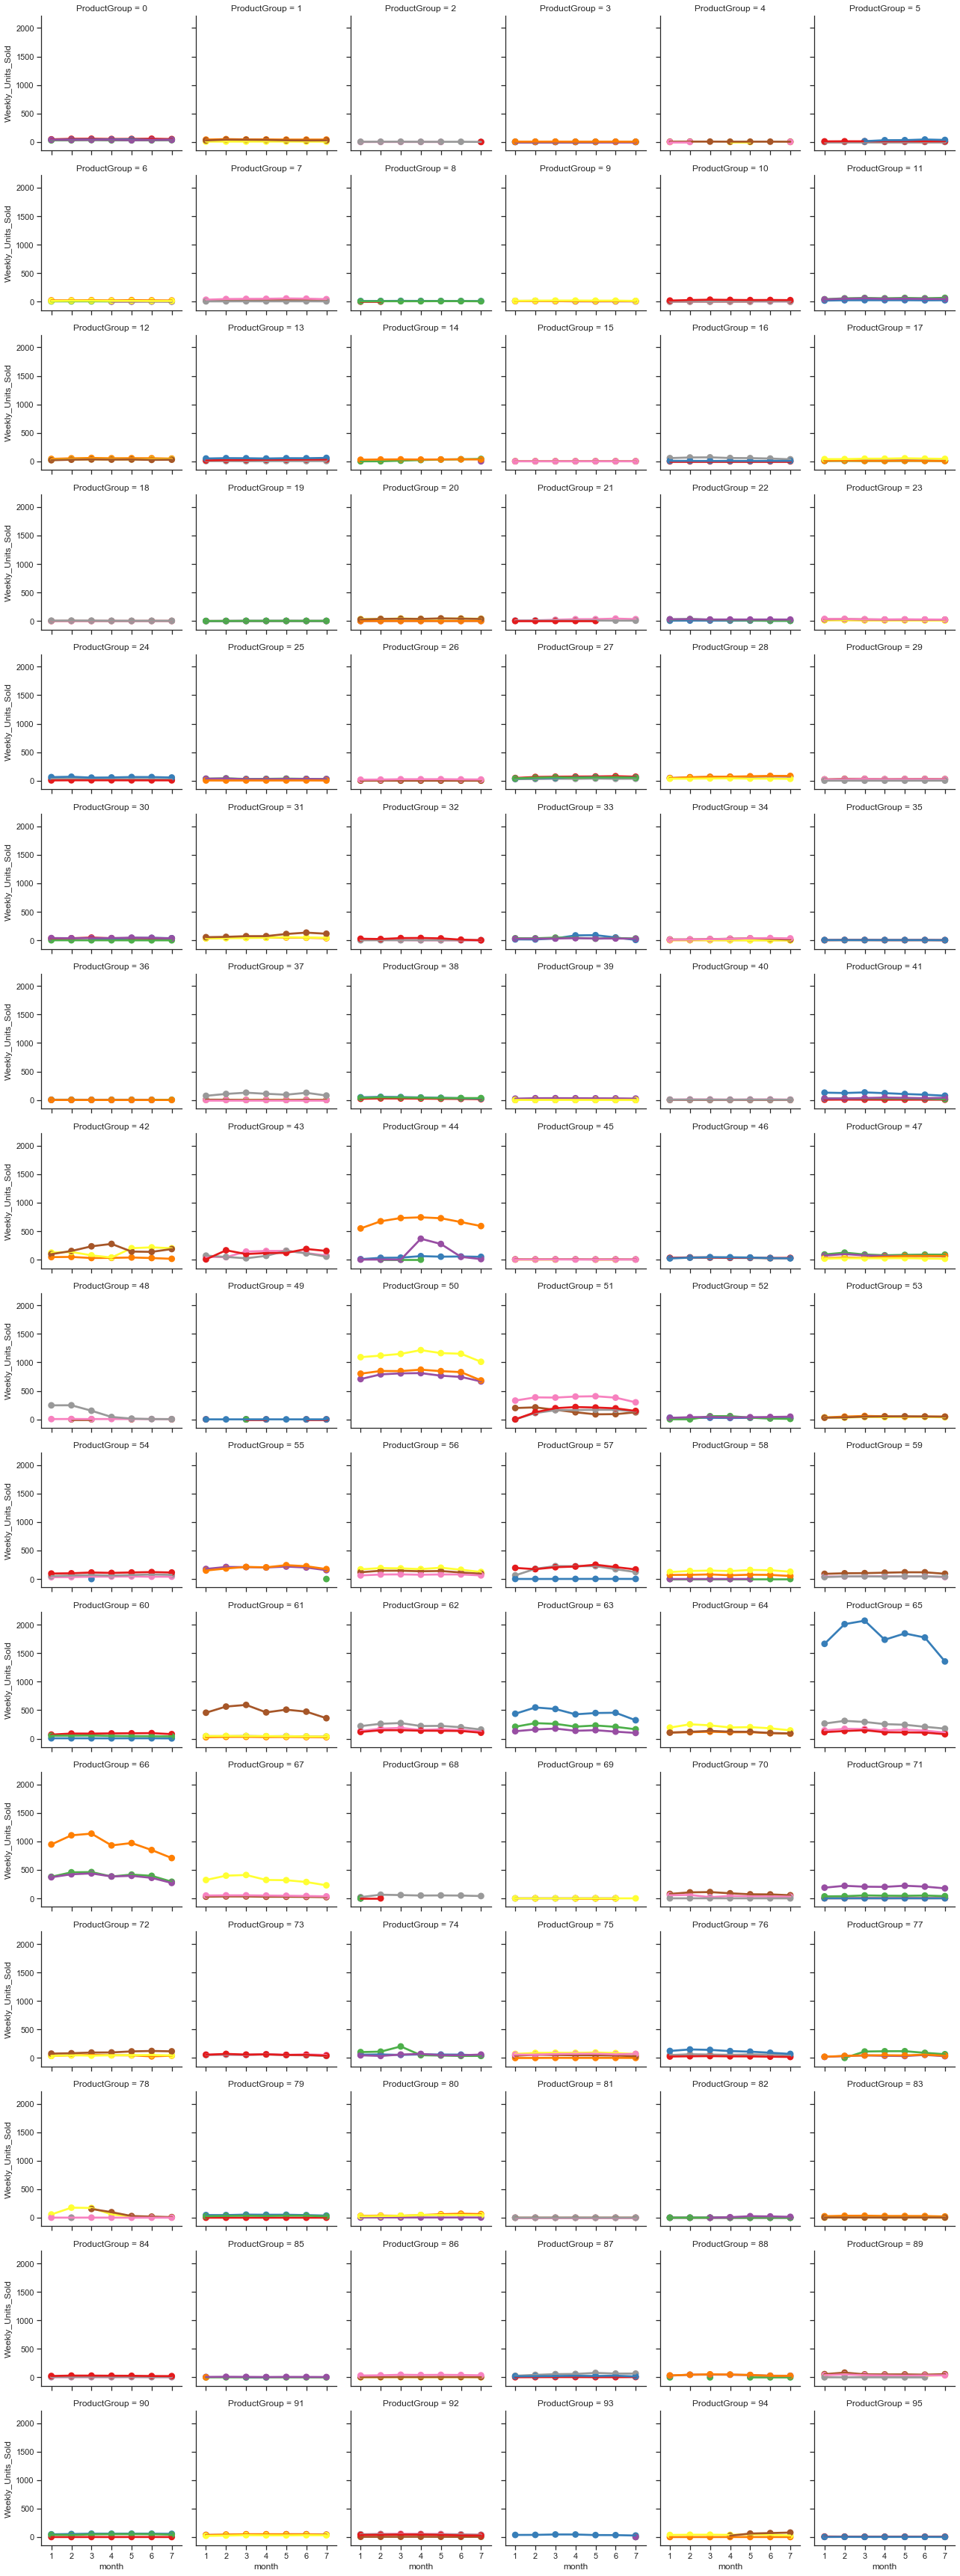

In [26]:
df_sales['ProductGroup'] = pd.cut(df_sales['ProductCode'],Ngroups, labels=False)
df_sales['month'] = df_sales.index.month
g = sns.FacetGrid(df_sales, col="ProductGroup", col_wrap=6, height=3,palette="Set1",hue='ProductCode')
g.map(sns.pointplot, "month", "Weekly_Units_Sold", ci=None, order = [1,2,3,4,5,6,7], alpha=.7)



The figure shown above that helping to observe seasonality and trend symptom for the all 317 products.
It can be easily stated that there is no common movement route for all 317 products during 7 months.

QUESTIONS-PART1:

a.	What are your criteria for separating Fast, Medium and Slow items? Why?

b.	Which items experienced the biggest sale increase during promotions?

c.	Is there any significant difference between promotion impacts of the Fast versus Slow items?

ANSWERS:

a. Separating products respect to weekly average sales quantities via Kernel Density Estimation.
   KDE is one of the most appropriate algorithm as to one feature unsupervised clustering.

b. ProductCode 218  has experienced the biggest sales experience by far.It has almost doubled from 1500 to 3000.

c. Although, slow group products has been also effected positively, fast group products has escalated more aggresively than
   those.
    

PART2: Time series-Analysing with Facebook Prophet

In [27]:
df_3 = pd.read_csv('C://Users/dell/.spyder-py3/Question3.3data.csv')

In [28]:
df_3['Date'] = pd.to_datetime(df_3['Date'], format='%Y-%m-%d') # formating date
mask = df_3['SalesQuantity'] < 0
df_3['Sales'] = df_3['SalesQuantity'].mask(mask)
df_3['Returns'] = df_3['SalesQuantity'].mask(~mask)
df_3.fillna(0,inplace=True)
df_3.drop(['SalesQuantity'],axis=1,inplace=True)
df_3.drop(['StoreCode'],axis=1,inplace=True)
df_sales_3=df_3.groupby(['Date','ProductCode']).Sales.sum().reset_index()
df_returns_3=df_3.groupby(['Date','ProductCode']).Returns.sum().reset_index()

In [29]:
df_sales_3.head()

,Date,ProductCode,Sales
0,2015-08-01,1,50.0
1,2015-08-01,2,25.0
2,2015-08-01,3,12.0
3,2015-08-01,4,30.0
4,2015-08-01,5,34.0


In [30]:
df_sales_3.set_index('Date',inplace=True)
df_sales_3=df_sales_3.groupby([pd.Grouper(freq='W'),'ProductCode'])
df_sales_3=df_sales_3['Sales'].sum().div(7)
df_sales_3=df_sales_3.round(0)

In [31]:
df_sales_3=df_sales_3.loc['20150809':'20151227']
df_sales_3=df_sales_3.to_frame()
df_sales_3=df_sales_3.reset_index(level=['Date','ProductCode'])
df_sales_3.columns=['Date','ProductCode','Weekly_Units_Sold']
df_concat=pd.concat([df_sales,df_sales_3],ignore_index=True)

In [32]:
df_sales_3.head()

,Date,ProductCode,Weekly_Units_Sold
0,2015-08-09,1,46.0
1,2015-08-09,2,46.0
2,2015-08-09,3,31.0
3,2015-08-09,4,32.0
4,2015-08-09,5,47.0


Prophet needs at least two data to make prediction.So, 
if any product Code having less than two week data, these should be filtered before applying prophet. 

In [33]:
df_gb = df_sales.groupby(['ProductCode'])['Weekly_Units_Sold'].apply(list).to_frame()

df_gb

,Weekly_Units_Sold
ProductCode,
1,"[49.0, 56.0, 35.0, 56.0, 59.0, 59.0, 49.0, 58...."
2,"[35.0, 43.0, 29.0, 43.0, 46.0, 43.0, 36.0, 42...."
3,"[33.0, 24.0, 29.0, 32.0, 20.0, 40.0, 27.0, 36...."
4,"[40.0, 48.0, 27.0, 30.0, 40.0, 39.0, 35.0, 36...."
5,"[53.0, 40.0, 33.0, 56.0, 45.0, 47.0, 53.0, 46...."
...,...
313,"[3.0, 23.0, 26.0, 43.0, 50.0, 38.0, 58.0, 79.0..."
314,"[1.0, 2.0, 2.0, 1.0, 3.0, 4.0, 3.0, 3.0, 2.0, ..."
315,"[3.0, 2.0, 2.0, 3.0, 2.0, 4.0, 3.0, 4.0, 2.0, ..."


In [34]:
df_gb['non_zero_lt_two'] = df_gb['Weekly_Units_Sold'].apply(lambda x: True if np.count_nonzero(np.array(x)) < 2 else False)
df_gb.head()

,Weekly_Units_Sold,non_zero_lt_two
ProductCode,,
1,"[49.0, 56.0, 35.0, 56.0, 59.0, 59.0, 49.0, 58....",False
2,"[35.0, 43.0, 29.0, 43.0, 46.0, 43.0, 36.0, 42....",False
3,"[33.0, 24.0, 29.0, 32.0, 20.0, 40.0, 27.0, 36....",False
4,"[40.0, 48.0, 27.0, 30.0, 40.0, 39.0, 35.0, 36....",False
5,"[53.0, 40.0, 33.0, 56.0, 45.0, 47.0, 53.0, 46....",False


In [35]:
prod_code_list = df_gb.index[df_gb['non_zero_lt_two'] == True].tolist()

a=list(df_sales.ProductCode.unique())
b=list(df_sales_3.ProductCode.unique())
c=list(set(a) - set(b))
prod_code_list.extend(c)
prod_code_list=np.sort(prod_code_list)
len(prod_code_list)

Also, if any productcode is not placed in df_sales_3 data, would also be appended trivial list.


In [36]:
df_sales= df_sales[~df_sales['ProductCode'].isin(prod_code_list)]
df_sales_3= df_sales_3[~df_sales_3['ProductCode'].isin(prod_code_list)]

Now, randomly choose and apply Prophet for one sample ProductCode

In [37]:
df_sales_145=df_sales[df_sales['ProductCode']==145]

In [38]:
df_sales_145.drop('ProductCode',axis=1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:
df_sales_145=df_sales_145.reset_index(level=['Date'])
df_sales_145=df_sales_145[['Date','Weekly_Units_Sold']].rename(columns={'Date':'ds','Weekly_Units_Sold':'y'})

In [40]:
model=Prophet(interval_width=0.95)
model.fit(df_sales_145)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


In [41]:
future_dates = model.make_future_dataframe(periods = 21, freq='W')

In [42]:
forecast = model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
43,2015-11-15,203.183101,106.323876,304.501568
44,2015-11-22,205.783453,105.157385,308.911985
45,2015-11-29,208.383806,116.591136,306.150162
46,2015-12-06,210.984158,117.233079,304.364494
47,2015-12-13,213.584511,117.185686,309.008473
48,2015-12-20,216.184863,121.485304,314.566785
49,2015-12-27,218.785216,118.856781,314.245858


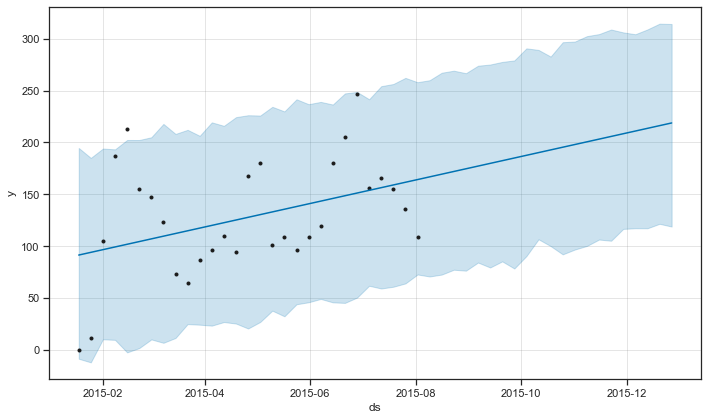

In [43]:
model.plot(forecast);

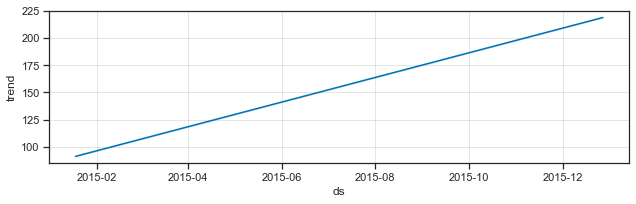

<Figure size 720x360 with 0 Axes>

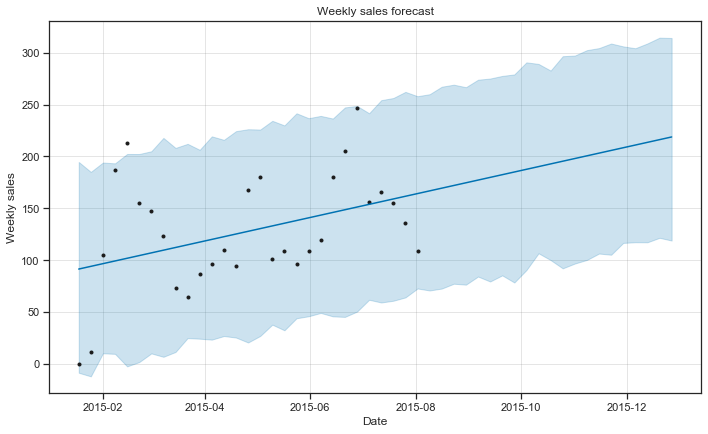

In [44]:
model.plot_components(forecast);

plt.figure(figsize=(10, 5))
model.plot(forecast, xlabel = 'Date', ylabel = 'Weekly sales')
plt.title('Weekly sales forecast');

In [45]:
df_sales_3_145=df_sales_3.query('ProductCode==145')
df_sales_3_145.drop('ProductCode',axis=1,inplace=True)
df_sales_3_145=df_sales_3_145[['Date','Weekly_Units_Sold']].rename(columns={'Date':'ds','Weekly_Units_Sold':'y'})
df_sales_3_145.head()


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,y
135,2015-08-09,143.0
418,2015-08-16,144.0
709,2015-08-23,165.0
995,2015-08-30,128.0
1279,2015-09-06,183.0


In [46]:
metric_df = forecast.set_index('ds')[['yhat']].join(df_sales_3_145.set_index('ds').y).reset_index()


In [47]:
metric_df.dropna(inplace=True)
metric_df.head()

,ds,yhat,y
29,2015-08-09,166.778164,143.0
30,2015-08-16,169.378517,144.0
31,2015-08-23,171.978869,165.0
32,2015-08-30,174.579222,128.0
33,2015-09-06,177.179575,183.0


In [48]:
error = mean_squared_error(metric_df.y, metric_df.yhat)
print('The RMSE is {}'. format(np.sqrt(error)))
print('The Mean is {}'.format(metric_df['y'].mean()))


The RMSE is 47.985202360138366
The Mean is 150.04761904761904


It could be worked better.Seasonality and promotion period adjustment is needed.

In [49]:
df_sales_145['Promo_Week'] =np.where((df_sales_145.ds=='2015-02-15') |(df_sales_145.ds=='2015-03-22')|(df_sales_145.ds=='2015-05-31')|(df_sales_145.ds=='2015-06-28'),True,False)
df_sales_145['Non_Promo_Week'] =np.where((df_sales_145.ds=='2015-02-15') |(df_sales_145.ds=='2015-03-22')|(df_sales_145.ds=='2015-05-31')|(df_sales_145.ds=='2015-06-28'),False,True)

In [50]:
future_promo = pd.DataFrame({'holiday': "Promo event",
                      'ds' : pd.to_datetime(['2015-01-09','2015-11-21']),
                      'lower_window': 0,
                      'upper_window': 7})
model = Prophet(interval_width=0.95,holidays=future_promo)
model.add_seasonality(name='Promo_Week', period=35, fourier_order=4,condition_name='Promo_Week')
# model.add_seasonality(name='Non_Promo_Week', period=60, fourier_order=1, condition_name='Non_Promo_Week')
model.fit(df_sales_145)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


In [53]:
forecast = model.make_future_dataframe(periods=21, freq='W')
forecast['Promo_Week'] = np.where((forecast.ds=='2015-09-06') |(forecast.ds=='2015-11-29'),True,False)
forecast['Non_Promo_Week'] =np.where((forecast.ds=='2015-09-06') |(forecast.ds=='2015-11-29'),False,True)

forecast = model.predict(forecast)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Promo event,Promo event_lower,Promo event_upper,Promo_Week,...,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-18,91.746388,1.282282,183.819370,91.746388,91.746388,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.746388
1,2015-01-25,93.952212,2.355473,185.570406,93.952212,93.952212,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.952212
2,2015-02-01,96.158035,8.361403,183.255656,96.158035,96.158035,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.158035
3,2015-02-08,98.363859,8.193871,178.595595,98.363859,98.363859,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.363859
4,2015-02-15,100.569682,13.071535,190.068734,100.569682,100.569682,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.569682


<Figure size 720x360 with 0 Axes>

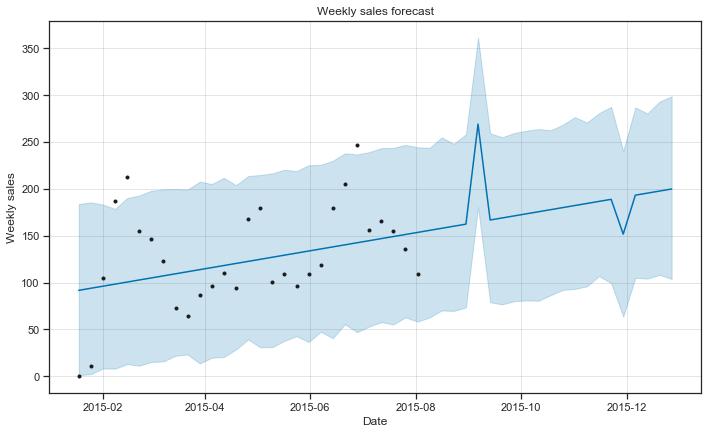

In [54]:
plt.figure(figsize=(10, 5))
model.plot(forecast, xlabel = 'Date', ylabel = 'Weekly sales')
plt.title('Weekly sales forecast');

In [55]:
df_sales_3_145

,ds,y
135,2015-08-09,143.0
418,2015-08-16,144.0
709,2015-08-23,165.0
995,2015-08-30,128.0
1279,2015-09-06,183.0
1563,2015-09-13,127.0
1851,2015-09-20,162.0
2131,2015-09-27,160.0
2418,2015-10-04,145.0
2701,2015-10-11,148.0


In [56]:
metric_df = forecast.set_index('ds')[['yhat']].join(df_sales_3_145.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
error = mean_squared_error(metric_df.y, metric_df.yhat)
print('The RMSE is {}'. format(np.sqrt(error)))

The RMSE is 36.53988669526598


I have tried to tunning optimal fourier and period parameter for all products. Thus, Rmse could be improve as if focusing on only ProductCode 145.But herd is more vital than individuals in this study.  

In [57]:
metric_df

,ds,yhat,y
29,2015-08-09,155.715270,143.0
30,2015-08-16,157.921094,144.0
31,2015-08-23,160.126917,165.0
32,2015-08-30,162.332741,128.0
33,2015-09-06,269.048023,183.0
34,2015-09-13,166.744388,127.0
35,2015-09-20,168.950211,162.0
36,2015-09-27,171.156035,160.0
37,2015-10-04,173.361858,145.0
38,2015-10-11,175.567682,148.0


This process should be applied all the other products automatically.For thiis reason, a function including for loop is generated. 

In [58]:
def get_prediction(df):
    prediction = {}
    
  
    df = df.rename(columns={'Date': 'ds', 'ProductCode': 'ProductCode','Weekly_Units_Sold': 'y'})
    list_products = np.sort(df['ProductCode'].unique())
    
    
    for product in list_products:
        
        
        products_df = df[df['ProductCode'] == product]
        products_df.drop('ProductCode',axis=1,inplace=True)
        products_df['ds'] = pd.to_datetime(products_df['ds'], format='%Y-%m-%d') 
        products_df['Promo_Week'] =np.where((products_df.ds=='2015-02-15') |(products_df.ds=='2015-03-22')|(products_df.ds=='2015-05-31')|(products_df.ds=='2015-06-28'),True,False)
        products_df['Non_Promo_Week'] =np.where((products_df.ds=='2015-02-15') |(products_df.ds=='2015-03-22')|(products_df.ds=='2015-05-31')|(products_df.ds=='2015-06-28'),False,True)
       
        model = Prophet(interval_width=0.95)
        model.add_seasonality(name='Promo_Week', period=35, fourier_order=4,condition_name='Promo_Week')
        model.fit(products_df)
        
        forecast = model.make_future_dataframe(periods=21, freq='W')
        forecast['Promo_Week'] = np.where((forecast.ds=='2015-09-06') |(forecast.ds=='2015-11-29'),True,False)
        forecast['Non_Promo_Week'] =np.where((forecast.ds=='2015-09-06') |(forecast.ds=='2015-11-29'),False,True)

        forecast = model.predict(forecast)
        forecast=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        forecast=forecast[forecast['ds'].between('2015-08-09','2015-12-27')]
          
    
        prediction[product] = forecast
      
    return prediction

In [59]:
df_sales=df_sales.reset_index(level=['Date'])
forecasted_products=get_prediction(df_sales)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [60]:
forecasted_products=pd.concat(forecasted_products).reset_index(level=0)
forecasted_products.head()

,level_0,ds,yhat,yhat_lower,yhat_upper
30,1,2015-08-09,49.908927,31.947738,67.163398
31,1,2015-08-16,49.750056,33.001213,67.340542
32,1,2015-08-23,49.591185,32.723152,66.764984
33,1,2015-08-30,49.432314,30.639296,67.118472
34,1,2015-09-06,72.395618,55.699688,88.596939


In [61]:
df_sales_3.head()

,Date,ProductCode,Weekly_Units_Sold
0,2015-08-09,1,46.0
1,2015-08-09,2,46.0
2,2015-08-09,3,31.0
3,2015-08-09,4,32.0
4,2015-08-09,5,47.0


In [62]:
df_sales_3.columns=['Date','ProductCode','y']
forecasted_products.columns=['ProductCode','Date','yhat','yhat_lower','yhat_upper']
forecasted_products.drop(['yhat_lower','yhat_upper'],axis=1,inplace=True)


In [63]:
df_all = forecasted_products.merge( df_sales_3,on=['Date','ProductCode'],how='left', indicator=True)
df_all.drop('_merge',axis=1,inplace=True)
df_all.dropna(inplace=True)

In [64]:
rmse=[]
product_mean=[]
list_products = np.sort(df_all['ProductCode'].unique())
ProductCode=[]
for i in list_products:
    temp_df = df_all[df_all['ProductCode'] ==i]
    error = mean_squared_error(temp_df.y, temp_df.yhat)
    squared_root_error= np.sqrt(error)
    product_mean_y=np.mean(temp_df['y'])
    rmse.append(squared_root_error)
    product_mean.append(product_mean_y)
    ProductCode.append(i)

final_error_table = pd.DataFrame()
final_error_table['ProductCode']=ProductCode
final_error_table['product_mean'] = product_mean
final_error_table['rmse'] = rmse
print(final_error_table.head())

   ProductCode  product_mean      rmse
0            1     45.904762  6.134999
1            2     35.761905  8.248616
2            3     25.761905  6.125684
3            4     32.571429  7.924169
4            5     34.857143  5.855701


Using final_error_table, it is easy to access any rmse score needed to analyze.
Let's look at rmse for ProductCode 210

In [91]:
final_error_table.query('ProductCode==210')

,ProductCode,product_mean,rmse
186,210,121.904762,18.539087


In [92]:
df_sales_3.head()

,Date,ProductCode,y
0,2015-08-09,1,46.0
1,2015-08-09,2,46.0
2,2015-08-09,3,31.0
3,2015-08-09,4,32.0
4,2015-08-09,5,47.0


df_sales_3 is our real data and I have tried to predict its values and inserted predictions to forecasted_products table.

In [93]:
df_sales_3_means= df_sales_3.groupby(['Date']).y.mean().reset_index()
df_sales_3_means.head()

,Date,y
0,2015-08-09,58.675090
1,2015-08-16,59.529197
2,2015-08-23,60.112319
3,2015-08-30,54.144404
4,2015-09-06,67.460145


In [96]:
forecasted_products_means= forecasted_products.groupby(['Date']).yhat.mean().reset_index()
forecasted_products_means.head()

,Date,yhat
0,2015-08-09,60.448332
1,2015-08-16,59.981458
2,2015-08-23,59.514583
3,2015-08-30,59.047708
4,2015-09-06,77.622845


Text(0, 0.5, 'Yhat')

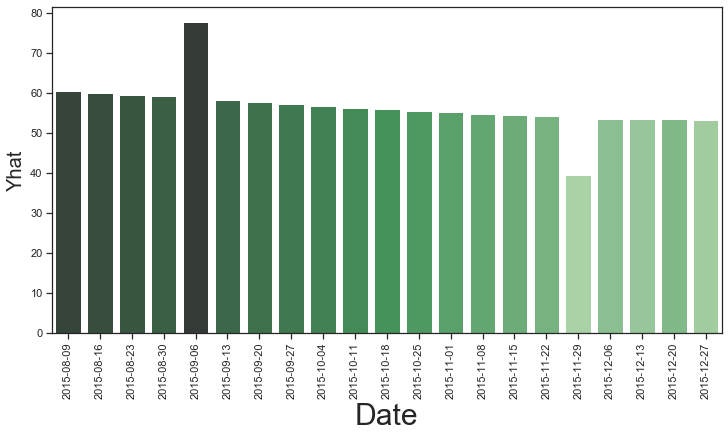

In [157]:
fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.barplot(x = "Date", y = "yhat", data = forecasted_products_means,palette=np.array(pal[::-1])[rank])

x_dates = forecasted_products_means['Date'].dt.strftime('%Y-%m-%d')
ax.set_xticklabels(labels=x_dates, rotation=60)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_xlabel("Date",fontsize=30)
ax.set_ylabel("Yhat",fontsize=20)

Text(0, 0.5, 'Y')

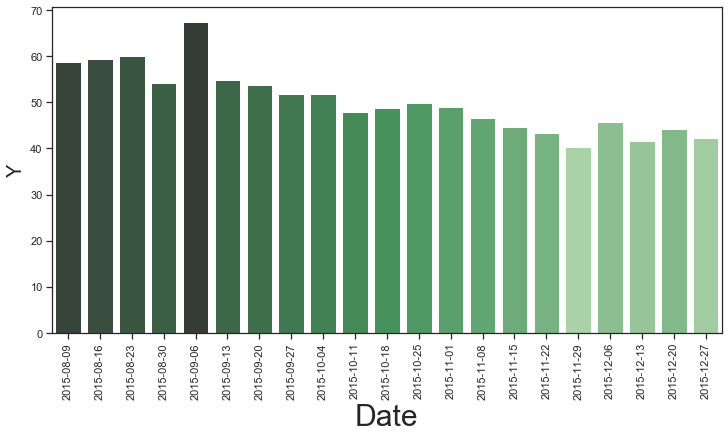

In [158]:
fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.barplot(x = "Date", y = "y", data = df_sales_3_means,palette=np.array(pal[::-1])[rank])

x_dates = df_sales_3_means['Date'].dt.strftime('%Y-%m-%d')
ax.set_xticklabels(labels=x_dates, rotation=60)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_xlabel("Date",fontsize=30)
ax.set_ylabel("Y",fontsize=20)

QUESTIONS-PART2:
    
a.What measure would you use for goodness of fit?

b.What are the main problem points causing bad fits?

c.What is the impact of Promo5&Promo6? Compare the result with predicted and the real data.

ANSWERS:

a.I have used root mean square error.Because it reflects both negative and postive errors without neutralising.

b.There is no common seasonality and trend direction followed by all the products.
  
  Only arrangement I could apply that turn over ensuring promo week as though a seasonal period,
  
  The data has tracked better fluctuation of these periods.

c.It can be confidently state that Promo5 has boosted strongly the sales to upward direction,whereas the Promo6 has counter-
  
  intuitivly negative effects on the weekly average sales.Data we have analyzed is produced randomly based on a native shoe     
  
  brand company. Hence, it is easy to understand that why sales were going downward trend from September to end of the year.All 
  
  the ready-made clothing sector had designed and released their new products at the beginning of year.As time passed, customers 
  
  interest reduced and this reflects directly to brand sales quantities.
  
  As it is seen from the last graphic, Promo5 has created significantly positive effect on sales.In my assumption,Promo5 week    
  success  is strongly correlated with starting fall semester season of formal education.Age range between 7-18 massively made   
  
  up the customer demographics.On the other hand, Company immediately retract the Promo6 week desicion.Further research would be 
  
  linked to explain the reason of the negative consequence.   

    